In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import lightkurve as lk
import warnings
warnings.filterwarnings("ignore")

In [2]:
def search(periodogram, left_perc, right_perc):
    max_p = 0
    ass_p = 0
    periods = periodogram.period.value
    powers = periodogram.power.value
    #print(periods, powers)
    delta = periods[len(periods)-1] - periods[0]
    left = periods[0] + delta*left_perc
    right = periods[len(periods)-1] - delta*right_perc
    for i in range(1,len(periods)):
        if(periods[i] > left and periods[i] < right):
            if(powers[i] > max_p):
                max_p = powers[i]
                ass_p = periods[i]
    return ass_p

In [26]:
def preprocess(data):    
    fig = plt.figure(figsize=(12,40))
    
    #store processed light curve(flux) data
    features = np.zeros(shape=(len(data),3192))
    percent = 0
    for i in range(37,60): 
        
        #create light curve for each sample
        lc = lk.LightCurve(time=time_x, flux=np.array(data[i,1:3193]).flatten())
        #lc.scatter()
        
        #detrend lightcurve
        lc = lc.flatten()
        
        #fil outliers with random noise
        lc_temp, bool_mask = lc.remove_outliers(return_mask=True)
        rands = np.random.normal(np.mean(lc.flux), np.std(lc.flux), np.count_nonzero(bool_mask))
        replica = lc.flux
        replica[bool_mask] = rands
        #lc.scatter()
        
        #normalize
        lc = lc.normalize(unit='ppm')
        #lc.scatter()
        
        #Phase folding using dominant frequencies from periodogram
        periodogram = lc.to_periodogram("bls")
        #periodogram.plot()
        period = search(periodogram, .01, .01) #trim edges of periodogram (BUG)
        #print(period)
        lc = lc.fold(period)
        features[i,:] = lc.flux
        #lc.scatter()
        
        if(((i / len(features)) * 100) > percent):
            print(percent, "%")
            percent += 1
            
        #graph all of them together
        ax = fig.add_subplot(13,3,i+1-37)
        ax.scatter(np.array(range(3192)),features[i,:])
    return features

0 %
1 %


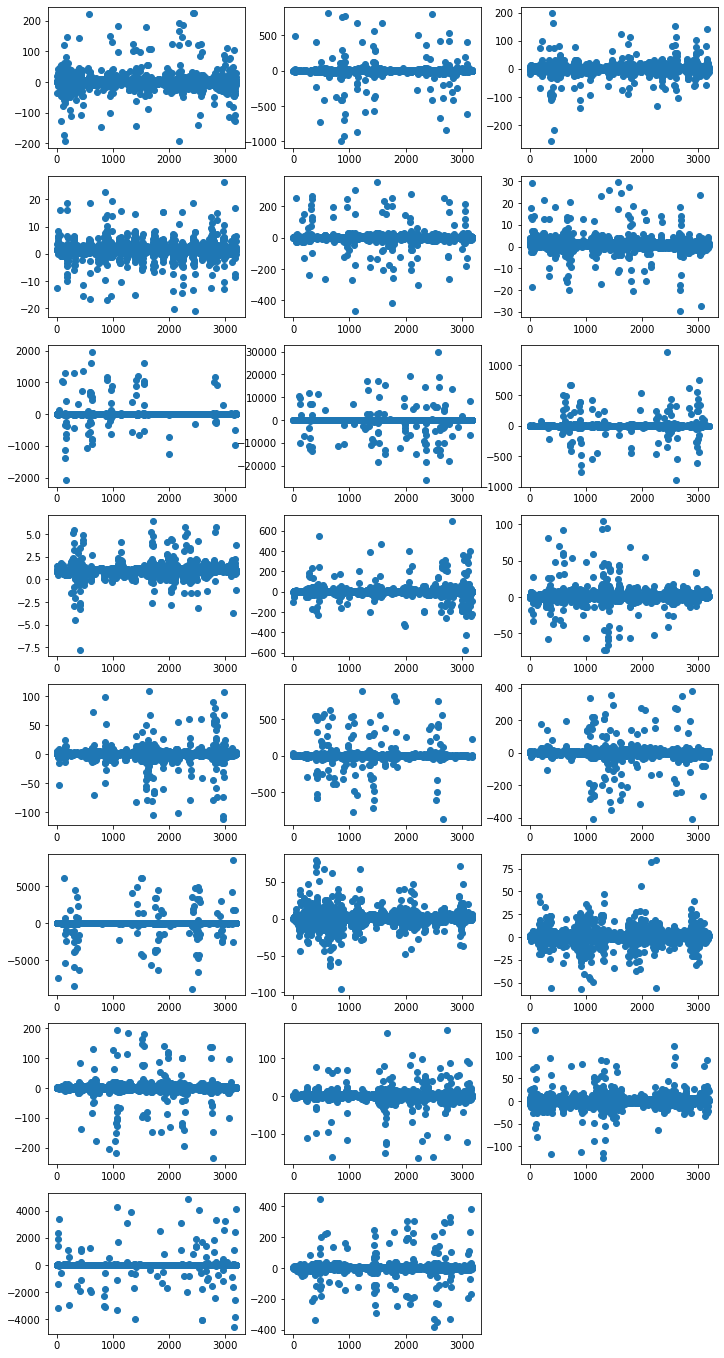